# Practical 5
## Pranay Kumar

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import bisect, minimize
from numpy import loadtxt
import emcee
import corner

In [14]:
plt.rcParams.update({'font.size': 16, 'text.usetex': True})

In [15]:
lens1 = np.reshape(loadtxt("/Users/pranaykumar/Documents/Python/lens1.txt", comments="#", delimiter=",", unpack=False),(4,3)) #Importing the data into a 4x3 matrix.
lens2 = np.reshape(loadtxt("/Users/pranaykumar/Documents/Python/lens2.txt", comments="#", delimiter=",", unpack=False),(4,3))

In [16]:
lens1x = lens1[:,0] # Seperating data for graphing below.
lens1y = lens1[:,1]
lens2x = lens2[:,0]
lens2y = lens2[:,1]
lens1un = lens1[:,2]
lens1uncertainty = lens2[:,2]

In [17]:
def xModel(gammac, gammas, b, u, v, x, y): # Taking in parameters and using it to convert the x and y values we are given into radius.
    r = np.sqrt((x**2) + (y**2))
    phiX = (b*x)/r + gammac*x + gammas*y
    modelX = u-phiX
    return modelX # Since U is equal to X minus phiX, we subtract phiX from U to find the model X.

def yModel(gammac, gammas, b, u, v, x, y):
    r = np.sqrt((x**2) + (y**2))
    phiY = (b*y)/r + gammac*x - gammas*y
    modelY = v-phiY
    return modelY #We do a very similar thing with V and Y as above.

In [18]:
def chi_sqlens1(parameters):
    gammac, gammas, b, v, u = parameters
    def file(a):
        dataX = lens1x[a] #The X data from the file
        dataY = lens1y[a] #The Y data from the file
        uncertainty = lens1uncertainty[a] #The uncertainty from the file
        modelX = xModel(gammac, gammas, b, u, v, dataX, dataY) #Creating the x model from the data
        modelY = yModel(gammac, gammas, b, u, v, dataX, dataY) #Creating the y model from the data
        return ((dataX - modelX)**2 + (dataY - modelY)**2) / uncertainty**2 # The primary component of the chi squared formula, we are squaring the difference in the observed and expected values for both x and y and then dividing by the uncertainty squared.
    chi = file(0) + file(1) + file(2) + file(3)
    return chi
def chi_sqlens2(parameters):
    gammac, gammas, b, v, u = parameters
    def file(a):
        dataX = lens2x[a] #The X data from the file
        dataY = lens2y[a] #The Y data from the file
        uncertainty = lens1uncertainty[a] #The uncertainty from the file
        modelX = xModel(gammac, gammas, b, u, v, dataX, dataY) #Creating the x model from the data
        modelY = yModel(gammac, gammas, b, u, v, dataX, dataY) #Creating the y model from the data
        return ((dataX - modelX)**2 + (dataY - modelY)**2) / uncertainty**2 # The primary component of the chi squared formula, we are squaring the difference in the observed and expected values for both x and y and then dividing by the uncertainty squared.
    chi = file(0) + file(1) + file(2) + file(3)
    return chi

In [19]:
parameters = [0.1, 0.1, 1, 1, 1] #The given arguments (gammaC, gammaS, b, v, and u) to use in the chi squared formula above for the data in lens1.
L1 = minimize(chi_sqlens1, parameters) # Using scipy.optimize minimize function to find the values of parameters when the function is minimized.
print(L1.x) # Printing the array calculated.
g_s1 = L1.x[0]; g_c1 = L1.x[1]; b1 = abs(L1.x[2]); v1 = L1.x[3]; u1 = L1.x[4] #Reading values from the results array into easier to variables to display
print("Lens 1:\ng_s: ", g_s1, "\ng_c:", g_c1, "\nb", b1, "\nv", v1, "\nu", u1) # Separating and reprinting the parameters to clean it up.

L2 = minimize(chi_sqlens2, parameters) #Doing the same as above for Lens 2.
print(L2.x)
g_s2 = L2.x[0]; g_c2 = L2.x[1]; b2 = abs(L2.x[2]); v2 = L2.x[3]; u2 = L2.x[4]
print("Lens 2:\ng_s: ", g_s2, "\ng_c:", g_c2, "\nb", b2, "\nv", v2, "\nu", u2)

[-0.18022503 -0.11888746 -1.17938391  0.10759365 -0.18624834]
Lens 1:
g_s:  -0.18022502990357864 
g_c: -0.11888745609160613 
b 1.1793839090338094 
v 0.10759365024647438 
u -0.18624833746061809
[ 0.03741389  0.0619169  -0.93354842  0.06526831  0.08248213]
Lens 2:
g_s:  0.03741388628132947 
g_c: 0.06191689810791702 
b 0.9335484161332855 
v 0.06526830817190603 
u 0.08248212510249223


In [20]:
def mu_inverse(r, theta, b, gammaC, gammaS):
    c = np.cos(theta) #Using c and s in place of x and y in the functions below since cartestian to polar is just rcos(theta) for x and rsin(theta) for y.
    s = np.sin(theta)
    phixx = b * s ** 2 / r + gammaC #The lens potential equations being written in terms of c, s, and radius.
    phiyy = b * c ** 2 / r - gammaC
    phixy = -b * c * s / r + gammaS
    return (1.0 - phixx) * (1.0 - phiyy) - phixy ** 2 # Returning the lens magnification equation.

def find_rcrit(theta, b, gammac, gammas):
    return bisect(mu_inverse, 1.0e-4 * b, 3.0 * b, args=(theta, b, gammac, gammas)) #Finding the roots of the lens magnification equation.

def calc_criticaus(b, gammac, gammas, title):
    tarr = np.linspace(0.0, 2.0 * np.pi, 100) #Generating theta values from 0 to 2pi.
    rarr = np.zeros(len(tarr)) #Generating radius values with the same length as the theta array above.

    for i in range(len(tarr)):
        rarr[i] = find_rcrit(tarr[i], b, gammac, gammas) # Running the bisect function for the entire length of the theta array, taking in accompanying radius values and the given b and shear values.

    xarr = rarr * np.cos(tarr) #Converting radius and theta values back to x and y.
    yarr = rarr * np.sin(tarr)

    phix = b * xarr / rarr + gammac * xarr + gammas * yarr # First derivative of lens potential with respect to x.
    phiy = b * yarr / rarr + gammas * xarr - gammas * yarr # First derivative of lens potential with respect to y.
    uarr = xarr - phix # Source plane position of x.
    varr = yarr - phiy # Source plane position of y.

    plt.figure(figsize=(3, 3), dpi=150) #Outlining the size and resolution of the graph.
    plt.title(title)
    plt.plot(xarr,yarr,'r',label='Critical Curve') #Plotting the results to find the critical curve
    plt.plot(uarr,varr,'b',label='Caustics') #Plotting the results to find the critical curve
    plt.legend(loc='upper left') #Placing the legend in the top left
    plt.show()

burn-in run
main run


/var/folders/zz/mqrj5zdn3wxcyfk2rn4vkms00000gn/T/ipykernel_44881/2837567142.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


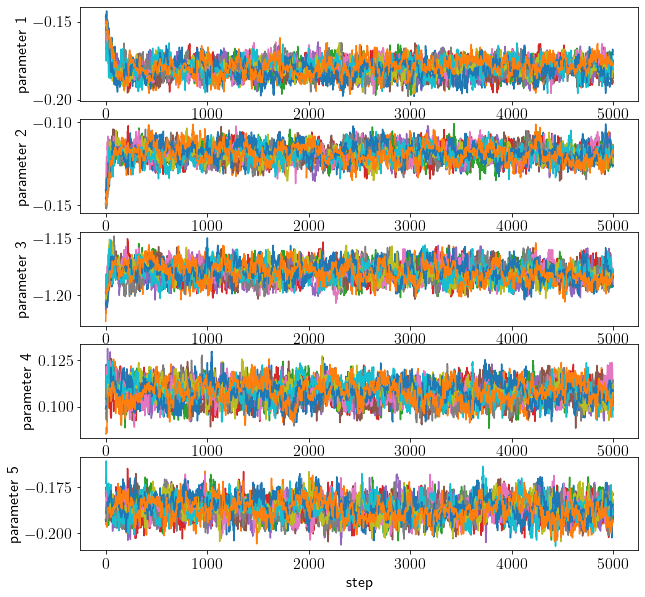

In [29]:
def lnprob(parameters):
    return -0.5*chi_sqlens1(parameters)
ndim = 5
nwalk = 12
nburn = 1000
nmain = 5000

# random starting points; we will take the strategy of perturbing some starting point
pstart = np.zeros(ndim)
p0 = np.array([ pstart+1.0e-4*np.random.normal(size=ndim) for iwalk in range(nwalk) ])

# set up the sampler
sampler = emcee.EnsembleSampler(nwalk,ndim,lnprob)

# burn-in run
print('burn-in run')
pos,prob,state = sampler.run_mcmc(p0,nburn)

# reset the sampler
sampler.reset()

# main run
print('main run')
res = sampler.run_mcmc(pos,nmain)
samples = sampler.chain.reshape((-1,ndim))
f,ax = plt.subplots(ndim,1,figsize=(10,10))
for idim in range(ndim):
    for iwalk in range(nwalk):
        ax[idim].plot(sampler.chain[iwalk,:,idim])
    ax[idim].set_xlabel('step')
    ax[idim].set_ylabel('parameter {}'.format(idim+1))
f.show()

/var/folders/zz/mqrj5zdn3wxcyfk2rn4vkms00000gn/T/ipykernel_44881/1001593664.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


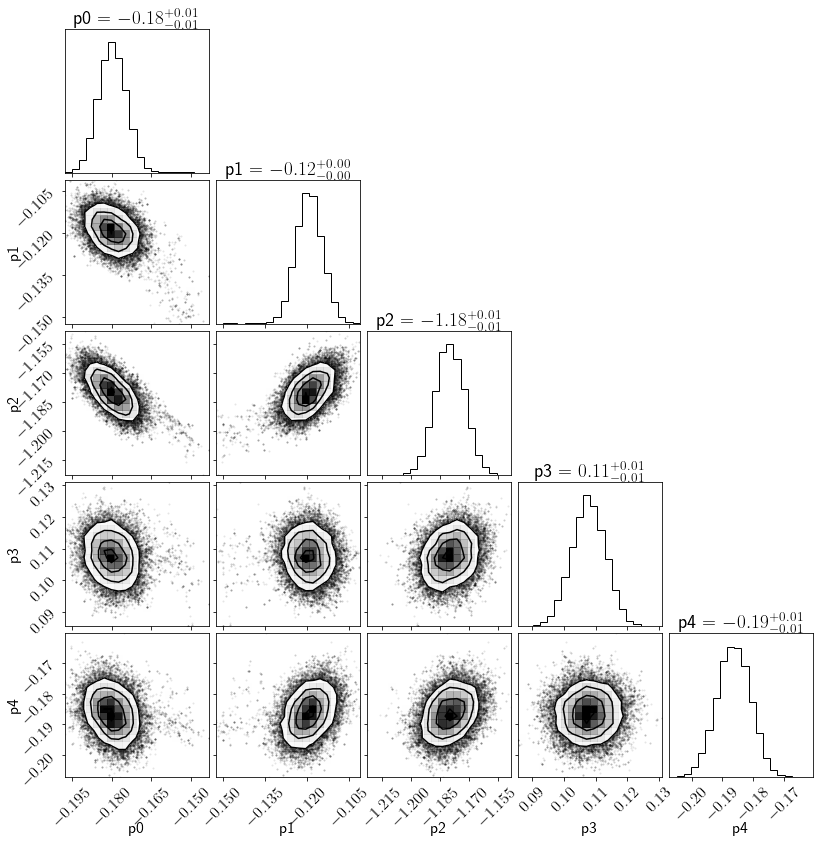

In [30]:
f = corner.corner(samples,show_titles=True,labels=('p0','p1','p2','p3','p4'))
f.show()

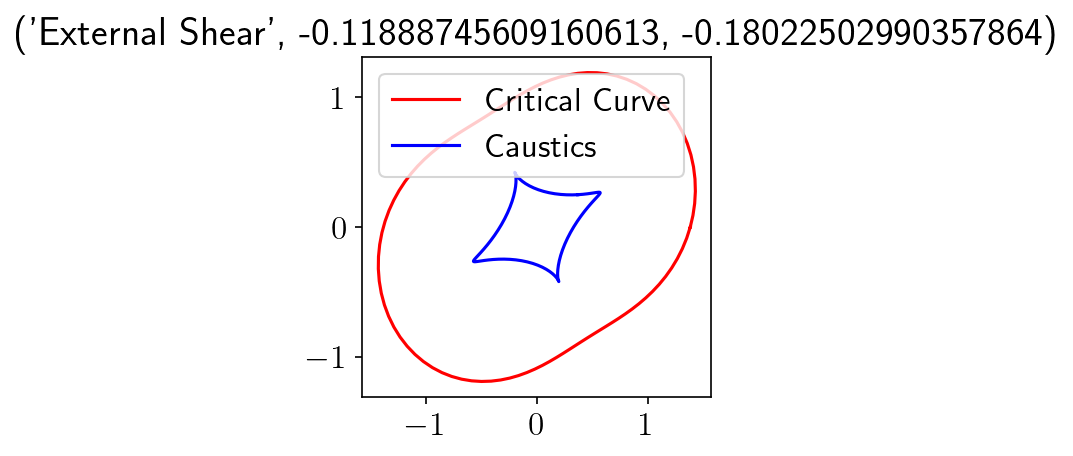

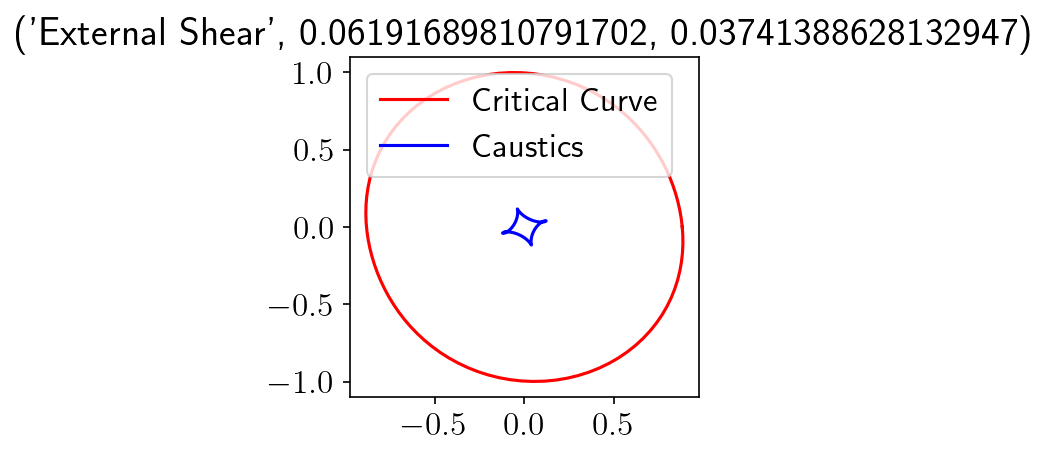

In [16]:
calc_criticaus(b1, g_c1, g_s1, ('External Shear',g_c1,g_s1))
calc_criticaus(b2, g_c2, g_s2, ('External Shear',g_c2,g_s2))